In [26]:
import pandas as pd
import numpy as np
import datetime as date
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("sap_storing_data_hu_project.csv")

C:\Python383\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


__1.1 Target variabele bepalen__

De target variabele waarnaar we willen gaan voorspellen wordt de eindtijd van de storing. 

__1.2 Inhoud en betekenis target variabele__


We willen voor elk ongeval voorspellen hoe lang de storing gaat duren, hiervoor willen we de eindtijd van de storing voorspellen. Om te kijken naar hoe snel eerdere problemen opgelost zijn hebben we een nieuwe variabele nodig: namelijk de tijd tussen het tijdstip van de melding van een ongeval en het tijdstip waarop het de storing verholpen is. 

In [4]:
df[['stm_sap_meld_ddt', 'stm_sap_storeind_ddt']]

,stm_sap_meld_ddt,stm_sap_storeind_ddt
0,NaN,NaN
1,02/01/2006 09:00:00,02/01/2006 09:00:00
2,02/01/2006 12:35:00,02/01/2006 13:26:00
3,02/01/2006 16:40:00,02/01/2006 17:20:00
4,02/01/2006 22:30:00,02/01/2006 22:36:00
...,...,...
898521,11/05/2013 08:06:00,11/05/2013 09:30:00
898522,11/05/2013 09:21:00,11/05/2013 10:44:00
898523,11/05/2013 09:21:00,11/05/2013 10:44:00
898524,20/08/2016 14:15:17,20/08/2016 15:15:00


__1.3 Target variabele geschikt maken voor model__

In [5]:
df['stm_sap_meld_ddt'] = pd.to_datetime(df['stm_sap_meld_ddt'], format='%d/%m/%Y %H:%M:%S')
df['stm_sap_storeind_ddt'] = pd.to_datetime(df['stm_sap_storeind_ddt'], format='%d/%m/%Y %H:%M:%S')
df['stm_fh_tijd'] = pd.to_timedelta(df['stm_fh_tijd'], unit='s')

In [6]:
# df['diff'] = datetime.strptime(df['stm_sap_meld_ddt'], FMT) - datetime.strptime(df['stm_sap_storeindtijd'], FMT).df['fh']
df['diff_meld_strend'] = df['stm_sap_storeind_ddt']-df['stm_sap_meld_ddt']

In [7]:
df[['diff_meld_strend','stm_sap_meld_ddt', 'stm_sap_storeind_ddt']]

,diff_meld_strend,stm_sap_meld_ddt,stm_sap_storeind_ddt
0,NaT,NaT,NaT
1,00:00:00,2006-01-02 09:00:00,2006-01-02 09:00:00
2,00:51:00,2006-01-02 12:35:00,2006-01-02 13:26:00
3,00:40:00,2006-01-02 16:40:00,2006-01-02 17:20:00
4,00:06:00,2006-01-02 22:30:00,2006-01-02 22:36:00
...,...,...,...
898521,01:24:00,2013-05-11 08:06:00,2013-05-11 09:30:00
898522,01:23:00,2013-05-11 09:21:00,2013-05-11 10:44:00
898523,01:23:00,2013-05-11 09:21:00,2013-05-11 10:44:00
898524,00:59:43,2016-08-20 14:15:17,2016-08-20 15:15:00


Nu tussen andere waardes, de tijd van melden en de tijd van functie herstel.

In [8]:
# df['stm_sap_meldtijd'] = pd.to_datetime(df['stm_sap_meldtijd'], format='%H:%M:%S', errors='coerce')
# df['stm_fh_tijd'] = pd.to_datetime(df['stm_fh_tijd'], format='%H:%M:%S', errors='coerce')

In [9]:
# df['diff_meld_fhtijd'] = (df['stm_fh_tijd'] - df['stm_sap_meldtijd'] )
# df['diff_meld_fhtijd2'] = (df['stm_sap_meldtijd'] - df['stm_fh_tijd'])

In [10]:
df.drop(df[df['stm_fh_duur'] > 360].index, inplace = True)
df.dropna(subset=['stm_fh_duur'],inplace=True)

Data dat iets is opgelost in de toekomst is onzin dus die verweideren.

In [11]:
df[df['stm_sap_storeind_ddt'] >= date.datetime.today()][['stm_sap_storeind_ddt','stm_sap_meld_ddt']]
df.drop(df[df['stm_sap_storeind_ddt'] >= date.datetime.today()][['stm_sap_storeind_ddt','stm_sap_meld_ddt']].index,inplace=True)

Een verschil van 10 jaar slaat ook nergens op.<br>
En de tijd van ernstige reparaties met spoed is altijd binnen dezelfde dag nog gedaan dus alles wat langer dan 6 uur duurt gaat er uit.

In [12]:
cols = ['stm_sap_meld_ddt','stm_sap_storeind_ddt','diff_meld_strend']
df.drop(df[df['stm_fh_tijd'] < pd.to_timedelta(6, unit='h')].index, inplace = True)

Rijen waar het probleem eerder is opgelost dan de melding is ook onbetrouwbare data.

In [13]:
# df.drop(df[df['diff_meld_strend'] < df['diff_meld_strend'][0]][cols].index, inplace = True)

KeyError: 0

In [14]:
# neg = df[df['diff_meld_strend'] < df['diff_meld_strend'][0]][cols]
# print(neg.shape)# 262 meldingen NA dat de storing was opgelost
# display(neg)
# display(neg.describe())

In [15]:
pos = df[df['diff_meld_strend'] > df['diff_meld_strend'][0]][cols]
print(pos.shape)# 659813 meldingen NA dat de storing was opgelost
display(pos)
display(pos.describe())

KeyError: 0

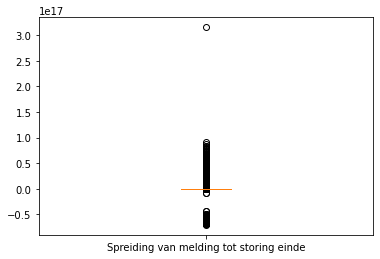

In [16]:
box_all = plt.boxplot(df['diff_meld_strend'],labels=['Spreiding van melding tot storing einde'])

In [17]:
box_pos = plt.boxplot(pos['diff_meld_strend'],labels=['Spreiding van melding tot storing einde'])

NameError: name 'pos' is not defined

Voor een baseline model kiezen we de meest voorkomende tijd.<br>
Dat is het getal dat je onder de mediaan vind: `02:17:00`.
<br><br>
Als baseline zeggen we dan ook: "Alle storingen duren 2 uur en 17 minuten.".

In [18]:
baseline = date.timedelta(hours=2,minutes=17)
amntInTime = df[df['diff_meld_strend'] < baseline][cols].count()[0]
total = df.shape[0]
print(f'{amntInTime / total * 100}% van de tijd heeft het baseline model het goed.')

46.30099821894545% van de tijd heeft het baseline model het goed.


In [19]:
pd.to_timedelta(6, unit='h')

Timedelta('0 days 06:00:00')

In [20]:
minutes = df['stm_fh_duur']

In [21]:
minutes

1          0.0
2         51.0
3         40.0
4          6.0
5          7.0
          ... 
898521    83.0
898522    83.0
898523    83.0
898524    19.0
898525    19.0
Name: stm_fh_duur, Length: 482860, dtype: float64

In [22]:
baseline = date.timedelta(hours=2,minutes=17)
baseline = baseline.seconds / 60
pred = [int(baseline)]*df[['stm_fh_duur']].shape[0]
r2_score(df[['stm_fh_duur']],pred)

-0.19871630651480054

In [27]:
np.sqrt(mean_squared_error(df[['stm_fh_duur']],pred))

90.57832768685704